In [98]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}

In [97]:
#setup
from FrontPanelAPI import ok
import time
import numpy as np
import cv2

dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")

Device[0] Model: 21
Device[0] Serial: 143400091C


0

In [72]:
#please close aperture

In [142]:
#grab 100 frames with aperture closed to obtain offset
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():
    row = 160
    N_adc = 4
    N_adcCh = 3
    N_mux = 46
    col = N_adc*N_adcCh*N_mux
    datain128 = bytearray(262144)
    datain1 = bytearray(88320)
    im = np.zeros((row ,col), np.uint8)
    im1 = np.zeros((79 ,60), np.uint8)
    im2 = np.zeros((79 ,60), np.uint8)
    
    exp =3
    exposure = int(10**exp)
    
    while exp<4.8:
        offset1 = np.zeros((79,60))
        elsecounter = 0   
        rep = 0
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.01)
        while rep<120:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                rep+=1
                if np.any(im1):
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>10:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()

            if (rep)%10 ==0:
                print rep 
        offset1= offset1/100
        cv2.imwrite(str(exposure)+'.png',offset1) #save offset images
        exp +=0.05
        exposure = int(10**exp)
else:
    print("FrontPanel host interface not detected.")

Device[0] Model: 21
Device[0] Serial: 143400091C
10
20
30
40
50
60
70
80
90
100
110
120
10


KeyboardInterrupt: 

In [141]:
#if image did not turn out well, do that one manually
exposures = [1000]
for exposure in exposures:
    offset1 = np.zeros((79,60))
    elsecounter = 0   
    rep = 0
    dev.SetWireInValue(0x11,int(exposure))
    dev.SetWireInValue(0x12,1)
    dev.SetWireInValue(0x13,0)
    dev.SetWireInValue(0x14,0)
    dev.SetWireInValue(0x15, 0xfff003ff)
    dev.UpdateWireIns()
    # assert reset signal to initialize the FIFO
    dev.SetWireInValue(0x10, 0xff, 0x01)
    dev.UpdateWireIns()
    # deactivate reset signal and activate counter.
    dev.SetWireInValue(0x10, 0x00, 0x01)
    dev.UpdateWireIns()
    time.sleep(0.01)
    while rep<120:
        dev.UpdateTriggerOuts()
        # If the FIFO is full, read everything and display one frame only
        if dev.IsTriggered(0x6A, 0x01) == True:
            dev.ReadFromPipeOut(0xA0, datain128)
            for i in range(row):
                for j in range(N_adc):
                    for k in range(N_adcCh):
                        for l in range(N_mux):
                            im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
            #im = im/255
            im1[:,:] = im[1:80,142:262:2]
            if np.any(im1>100):
                # assert reset signal to initialize the FIFO
                dev.SetWireInValue(0x10, 0xff, 0x01)
                dev.UpdateWireIns()
                # deactivate reset signal and activate counter.
                dev.SetWireInValue(0x10, 0x00, 0x01)
                dev.UpdateWireIns() 
            elif np.any(im1):
                rep+=1
                if rep>20: #to account for noise at the beginning
                    offset1 +=im1

        # If one frame is ready in FIFO
        elif dev.IsTriggered(0x6A, 0x02) == True:
            dev.ReadFromPipeOut(0xA0, datain1)
            for i in range(row):
                for j in range(N_adc):
                    for k in range(N_adcCh):
                        for l in range(N_mux):
                            im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]
            #im = im/255
            im1[:,:] = im[1:80,142:262:2]
            if np.any(im1>100):
                # assert reset signal to initialize the FIFO
                dev.SetWireInValue(0x10, 0xff, 0x01)
                dev.UpdateWireIns()
                # deactivate reset signal and activate counter.
                dev.SetWireInValue(0x10, 0x00, 0x01)
                dev.UpdateWireIns() 
            elif np.any(im1):
                rep+=1
                if rep>20: #to account for noise at the beginning
                    offset1 +=im1
        else:
            elsecounter += 1
            print elsecounter
            if elsecounter>10:
                elsecounter =0
                # assert reset signal to initialize the FIFO
                dev.SetWireInValue(0x10, 0xff, 0x01)
                dev.UpdateWireIns()
                # deactivate reset signal and activate counter.
                dev.SetWireInValue(0x10, 0x00, 0x01)
                dev.UpdateWireIns()

        if (rep)%10 ==0:
            print rep 
    offset1= offset1/100
    cv2.imwrite(str(exposure)+'.png',offset1) #save offset images

0
0
1
10
10
10
20
20
30
30
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
40
40
40
1
2
3
4
5
6
7
8
9
10
11
50
50
1
60
60
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
70
70
80
1
80
80
2
90
90
3
100
100
100
4
5
6
7
8
9
10
11
110
110
1
120


In [47]:
#please open aperture and expose camera to even illumination


[[34 36 33 ..., 29 32 31]
 [41 34 34 ..., 31 32 32]
 [33 32 35 ..., 31 28 33]
 ..., 
 [35 34 36 ..., 28 38 31]
 [33 35 35 ..., 30 35 28]
 [34 33 34 ..., 29 32 29]]


array([4, 8])

In [158]:
#grab 100 frames with aperture open to obtain signal 
#might have to manually change exposure due to issues with camera 
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():
    
    
    exp =3
    exposure = int(10**exp)
    
    while exp<4.8:
        row = 160
        N_adc = 4
        N_adcCh = 3
        N_mux = 46
        col = N_adc*N_adcCh*N_mux
        datain128 = bytearray(262144)
        datain1 = bytearray(88320)
        im = np.zeros((row ,col), np.uint8)
        im1 = np.zeros((79 ,60), np.uint8)
        im2 = np.zeros((79 ,60), np.uint8)
        data1 = np.zeros((100,79,60))
        imgcheck = np.zeros((79,60))
        elsecounter = 0 
        rep = 0
        print exposure
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        time.sleep(0.1)
        dev.UpdateWireIns()
        time.sleep(0.1)
        
        while rep<120:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    

                    im1 = im1- offset1
                    rep+=1
                    if rep>20: #to account for noise at the beginning
                        imgcheck+=im1
                        data1[rep-21] =im1
                
            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):

                    im1 = im1- offset1
                    rep+=1
                    if rep>20: #to account for noise at the beginning
                        imgcheck+=im1
                        data1[rep-21] =im1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>10:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()

            if (rep)%10 ==0:
                print rep 
        #compute the standard deviation and average signal of each pixel 
        imgcheck = imgcheck/100 
        cv2.imwrite(str(exposure)+'test.png', imgcheck)#make sure the data is ok
        pixstd1 = np.zeros((79,60))
        pixmean1 = np.zeros((79,60))
        pixvar1 = np.zeros((79,60))
        for row in range(79):
            for col in range(60):
                pixstd1[row,col] = np.std(data1[:,row,col])
                pixmean1[row,col] = np.mean(data1[:,row,col])
                pixvar1[row,col] = np.var(data1[:,row,col])
        stdDict1[exposure] = pixstd1
        meanDict1[exposure] = pixmean1
        varDict1[exposure] = pixvar1
        exp +=0.05
        exposure = int(10**exp)
else:
    print("FrontPanel host interface not detected.")

Device[0] Model: 21
Device[0] Serial: 143400091C
79432
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
10
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
1
2
3


KeyboardInterrupt: 

In [164]:
import pickle

#save dictionaries

with open('stdDict1.pkl', 'wb') as output:
    pickle.dump(stdDict1, output)

with open('meanDict1.pkl', 'wb') as output:
    pickle.dump(meanDict1, output)
    
with open('varDict1.pkl', 'wb') as output:
    pickle.dump(varDict1, output)    


[1584, 39810, 6309, 31622, 7943, 1000, 1258, 1995, 3981, 2511, 10000, 15848, 5011, 12589, 63095, 50118, 3162, 19952, 25118]
[1584, 39810, 6309, 31622, 7943, 1000, 1258, 1995, 3981, 2511, 10000, 15848, 5011, 12589, 63095, 50118, 3162, 19952, 25118]


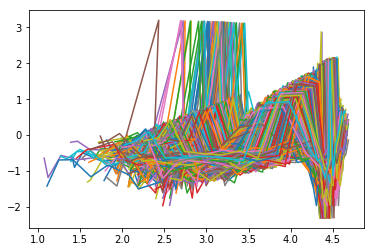

In [183]:
import math
import matplotlib.pyplot as plt
import numpy as np
#load dictionaries to plot data
with open('stdDict1.pkl', "rb") as fp:
    stdDict = pickle.load(fp) 

with open('meanDict1.pkl', "rb") as fp:
    meanDict = pickle.load(fp) 
    
with open('varDict1.pkl', "rb") as fp:
    varDict = pickle.load(fp)   
logmean= np.zeros((79,60,len(stdDict.keys())))
lognoise= np.zeros((79,60,len(stdDict.keys())))
i = 0
for key in sorted(stdDict.keys()):
    for row in range(79):
        for col in range(60):

            logmean[row,col,i] = math.log(meanDict[key][row, col])
            try:
                lognoise[row,col, i] = math.log(stdDict[key][row,col])
            except:
                lognoise[row,col, i] = 0
    
    i +=1
for row in range(79):
    for col in range(60):
        plt.plot(logmean[row, col], lognoise[row,col])
plt.show()

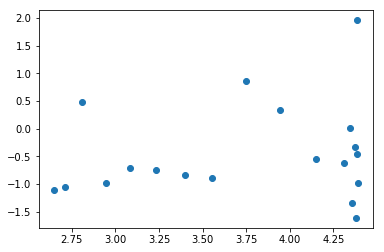

In [184]:
plt.plot(logmean[0, 0], lognoise[0,0],'o')
plt.show()